## Classifier-free guidance (for class-aware data augmentation)

In [1]:
import importlib
from pathlib import Path
import sys
sys.path.append('..')
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam
import torchvision

from src.diffusion import classifier_free_guidance as cfg
from src import trainhelper as th
from src import dataset
from src import viz

importlib.reload(th)
importlib.reload(dataset)
importlib.reload(viz)

/home/nashir/miniconda3/envs/cap5516-final/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.viz' from '/home/nashir/Documents/UCF/spring2023/cap5516/final-project/notebooks/../src/viz.py'>

## Load images, compute mean and std for normalization, then reload as downscaled

In [2]:
datadir = "../data/chest_xray"
dataloaders, dataset_sizes, class_names = dataset.load_xray_data(datadir, return_val_set=False, batch_size=8, load_as_rgb=False)
# Compute approximate mean and std of train dataset based on a single batch
images, _ = next(iter(dataloaders['train']))
# shape of images = [b,c,w,h]
mean, std = images.mean([0,2,3]), images.std([0,2,3])
# Reload downscaled dataset with mean and std computed above
transform = dataset.get_downscale_transforms(mean, std, load_as_rgb=False)
dataloaders, dataset_sizes, class_names = dataset.load_xray_data(datadir, transform, batch_size=4)

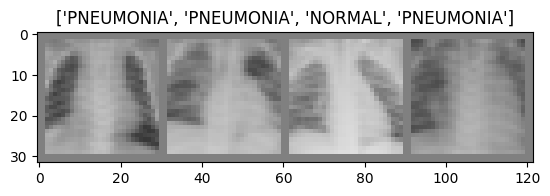

In [3]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

viz.imshow(out, mean, std, title=[class_names[x] for x in classes])

# Train diffusion on downsampled images, 28x28

In [4]:
image_size = 28
channels = 1
timesteps = 500
lr = 0.0001
batch_size = 4

In [5]:
# xray
label_map = {
    0: "Normal",
    1: "Pneumonia"
}
dataloader = dataloaders['train']

num_classes = 2
channels = 1

In [7]:
model = cfg.Unet(
    dim = 64,
    channels=channels,
    dim_mults = (1, 2, 4,),
    num_classes = num_classes,
    cond_drop_prob = 0.5
)

# Load unet from 4/26/23
model.load_state_dict(torch.load("../results/models/xray-unet-04-26-2023--17-27.pt"))

# TODO: load optimizer state dict
optimizer = Adam(model.parameters(), lr=lr)

diffusion = cfg.GaussianDiffusion(
    model,
    image_size = image_size,
    timesteps = timesteps
).cuda()

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
results_folder = Path("../results")
results_folder.mkdir(exist_ok = True)

In [13]:
# How often (# steps) to log losses to console
log_every = 500
# How often (# epochs) to sample generative model during training
sample_every = 5
epochs = 250

In [11]:
# losses = []

In [12]:
losses = torch.load("../results/losses/xray-unet-04-26-2023--17-27.pt")
losses, len(losses)

([[0.9030766487121582,
   0.9594429731369019,
   0.8023419976234436,
   0.7461369633674622,
   0.7428982853889465,
   0.6780493259429932,
   0.7600138187408447,
   0.705862820148468,
   0.655642569065094,
   0.6939743161201477,
   0.7203531861305237,
   0.6090995669364929,
   0.6248193979263306,
   0.5753144025802612,
   0.7300338745117188,
   0.5023006200790405,
   0.48795440793037415,
   0.5078485608100891,
   0.5782244801521301,
   0.441135436296463,
   0.5553462505340576,
   0.564522385597229,
   0.5353485941886902,
   0.375718355178833,
   0.41603735089302063,
   0.46660366654396057,
   0.4822750389575958,
   0.42317405343055725,
   0.5709477663040161,
   0.40193334221839905,
   0.4195733368396759,
   0.4763462245464325,
   0.5823874473571777,
   0.4275549650192261,
   0.45146268606185913,
   0.4904034435749054,
   0.4205006957054138,
   0.4190521538257599,
   0.37710779905319214,
   0.4292655289173126,
   0.669060468673706,
   0.4905688166618347,
   0.6088911294937134,
   0.48152

In [14]:
t0 = time.time()
th.train_classifier_free_guidance(epochs, model, dataloader, optimizer, device, diffusion,
                                  results_folder, label_map, losses, log_every, sample_every,
                                  model_name="xray-unet", cond_scale=3.)
t1 = time.time()

Starting training at 04-26-2023--23-31, sampling every 5 epochs, saving to ../results
Epoch 0
Loss at step 0: 0.15528830885887146
Loss at step 500: 0.3466051518917084
Loss at step 1000: 0.1657962054014206
Epoch 1
Loss at step 0: 0.16378144919872284
Loss at step 500: 0.263521283864975
Loss at step 1000: 0.22505846619606018
Epoch 2
Loss at step 0: 0.38138142228126526
Loss at step 500: 0.33638623356819153
Loss at step 1000: 0.3992340564727783
Epoch 3
Loss at step 0: 0.14311820268630981
Loss at step 500: 0.4241628050804138
Loss at step 1000: 0.2198656052350998
Epoch 4
Loss at step 0: 0.2028198540210724
Loss at step 500: 0.2289659082889557
Loss at step 1000: 0.2063957154750824
Epoch 5
Loss at step 0: 0.3983018696308136
Loss at step 500: 0.1864556223154068
Loss at step 1000: 0.23221367597579956


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.46it/s]


Epoch 6
Loss at step 0: 0.4506855309009552
Loss at step 500: 0.19447389245033264
Loss at step 1000: 0.3468301296234131
Epoch 7
Loss at step 0: 0.19306285679340363
Loss at step 500: 0.2018238753080368
Loss at step 1000: 0.19264675676822662
Epoch 8
Loss at step 0: 0.2020559012889862
Loss at step 500: 0.20278029143810272
Loss at step 1000: 0.23705019056797028
Epoch 9
Loss at step 0: 0.3069766163825989
Loss at step 500: 0.30607324838638306
Loss at step 1000: 0.2618420422077179
Epoch 10
Loss at step 0: 0.15013426542282104
Loss at step 500: 0.2527885437011719
Loss at step 1000: 0.20015846192836761


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 11
Loss at step 0: 0.324377179145813
Loss at step 500: 0.26210150122642517
Loss at step 1000: 0.35232409834861755
Epoch 12
Loss at step 0: 0.20715808868408203
Loss at step 500: 0.24848026037216187
Loss at step 1000: 0.2946997582912445
Epoch 13
Loss at step 0: 0.31793829798698425
Loss at step 500: 0.42975324392318726
Loss at step 1000: 0.3327620327472687
Epoch 14
Loss at step 0: 0.2771877944469452
Loss at step 500: 0.3115095794200897
Loss at step 1000: 0.33742859959602356
Epoch 15
Loss at step 0: 0.3933790624141693
Loss at step 500: 0.23835302889347076
Loss at step 1000: 0.31673136353492737


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 16
Loss at step 0: 0.29976901412010193
Loss at step 500: 0.2655957341194153
Loss at step 1000: 0.30974000692367554
Epoch 17
Loss at step 0: 0.18335309624671936
Loss at step 500: 0.3325725495815277
Loss at step 1000: 0.11560829728841782
Epoch 18
Loss at step 0: 0.3432588279247284
Loss at step 500: 0.3254360854625702
Loss at step 1000: 0.3147588074207306
Epoch 19
Loss at step 0: 0.36569342017173767
Loss at step 500: 0.2719595730304718
Loss at step 1000: 0.2810138761997223
Epoch 20
Loss at step 0: 0.2588270604610443
Loss at step 500: 0.24377773702144623
Loss at step 1000: 0.2584633529186249


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 21
Loss at step 0: 0.19958528876304626
Loss at step 500: 0.24117963016033173
Loss at step 1000: 0.28324246406555176
Epoch 22
Loss at step 0: 0.22242732346057892
Loss at step 500: 0.31089308857917786
Loss at step 1000: 0.2716786563396454
Epoch 23
Loss at step 0: 0.2588688135147095
Loss at step 500: 0.16369469463825226
Loss at step 1000: 0.319888174533844
Epoch 24
Loss at step 0: 0.21239618957042694
Loss at step 500: 0.22691644728183746
Loss at step 1000: 0.3005472719669342
Epoch 25
Loss at step 0: 0.3840222954750061
Loss at step 500: 0.21689479053020477
Loss at step 1000: 0.2268848419189453


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.46it/s]


Epoch 26
Loss at step 0: 0.3577353060245514
Loss at step 500: 0.18634366989135742
Loss at step 1000: 0.4426904320716858
Epoch 27
Loss at step 0: 0.313247948884964
Loss at step 500: 0.15177838504314423
Loss at step 1000: 0.15730436146259308
Epoch 28
Loss at step 0: 0.17680351436138153
Loss at step 500: 0.25921326875686646
Loss at step 1000: 0.3394559621810913
Epoch 29
Loss at step 0: 0.2535044252872467
Loss at step 500: 0.301046758890152
Loss at step 1000: 0.1603544056415558
Epoch 30
Loss at step 0: 0.20097123086452484
Loss at step 500: 0.2852041721343994
Loss at step 1000: 0.43300390243530273


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 31
Loss at step 0: 0.23044519126415253
Loss at step 500: 0.23437713086605072
Loss at step 1000: 0.12722136080265045
Epoch 32
Loss at step 0: 0.13142573833465576
Loss at step 500: 0.13728347420692444
Loss at step 1000: 0.23727895319461823
Epoch 33
Loss at step 0: 0.2656902074813843
Loss at step 500: 0.34680435061454773
Loss at step 1000: 0.45801877975463867
Epoch 34
Loss at step 0: 0.2076290398836136
Loss at step 500: 0.3294222354888916
Loss at step 1000: 0.3623812794685364
Epoch 35
Loss at step 0: 0.28346651792526245
Loss at step 500: 0.19238752126693726
Loss at step 1000: 0.1939765363931656


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 36
Loss at step 0: 0.3593239486217499
Loss at step 500: 0.37578606605529785
Loss at step 1000: 0.3750998079776764
Epoch 37
Loss at step 0: 0.2547529637813568
Loss at step 500: 0.22150442004203796
Loss at step 1000: 0.3234650790691376
Epoch 38
Loss at step 0: 0.3247624933719635
Loss at step 500: 0.24760806560516357
Loss at step 1000: 0.16172081232070923
Epoch 39
Loss at step 0: 0.18726332485675812
Loss at step 500: 0.23128776252269745
Loss at step 1000: 0.27462488412857056
Epoch 40
Loss at step 0: 0.23901261389255524
Loss at step 500: 0.38872796297073364
Loss at step 1000: 0.21648651361465454


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 41
Loss at step 0: 0.21073642373085022
Loss at step 500: 0.38410839438438416
Loss at step 1000: 0.218405082821846
Epoch 42
Loss at step 0: 0.2227383255958557
Loss at step 500: 0.23275865614414215
Loss at step 1000: 0.3921251893043518
Epoch 43
Loss at step 0: 0.2339845895767212
Loss at step 500: 0.37147057056427
Loss at step 1000: 0.31323036551475525
Epoch 44
Loss at step 0: 0.18695609271526337
Loss at step 500: 0.2730844020843506
Loss at step 1000: 0.27424994111061096
Epoch 45
Loss at step 0: 0.21637102961540222
Loss at step 500: 0.2868672013282776
Loss at step 1000: 0.23015692830085754


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 46
Loss at step 0: 0.4489080011844635
Loss at step 500: 0.2378048151731491
Loss at step 1000: 0.27323296666145325
Epoch 47
Loss at step 0: 0.28894054889678955
Loss at step 500: 0.17753615975379944
Loss at step 1000: 0.11161747574806213
Epoch 48
Loss at step 0: 0.2313859909772873
Loss at step 500: 0.22301922738552094
Loss at step 1000: 0.23916953802108765
Epoch 49
Loss at step 0: 0.1652795821428299
Loss at step 500: 0.3747285008430481
Loss at step 1000: 0.18787726759910583
Epoch 50
Loss at step 0: 0.16031940281391144
Loss at step 500: 0.22903406620025635
Loss at step 1000: 0.32434985041618347


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 51
Loss at step 0: 0.27958324551582336
Loss at step 500: 0.28666889667510986
Loss at step 1000: 0.23862454295158386
Epoch 52
Loss at step 0: 0.23808875679969788
Loss at step 500: 0.22086545825004578
Loss at step 1000: 0.11516985297203064
Epoch 53
Loss at step 0: 0.29099389910697937
Loss at step 500: 0.40028801560401917
Loss at step 1000: 0.3235202729701996
Epoch 54
Loss at step 0: 0.16887781023979187
Loss at step 500: 0.11498986184597015
Loss at step 1000: 0.2605936825275421
Epoch 55
Loss at step 0: 0.21459458768367767
Loss at step 500: 0.23860600590705872
Loss at step 1000: 0.3680751621723175


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 56
Loss at step 0: 0.42497703433036804
Loss at step 500: 0.15121671557426453
Loss at step 1000: 0.2772221267223358
Epoch 57
Loss at step 0: 0.3588067591190338
Loss at step 500: 0.3779720366001129
Loss at step 1000: 0.12240524590015411
Epoch 58
Loss at step 0: 0.18593920767307281
Loss at step 500: 0.3178677558898926
Loss at step 1000: 0.20477761328220367
Epoch 59
Loss at step 0: 0.2662130296230316
Loss at step 500: 0.23643742501735687
Loss at step 1000: 0.16737225651741028
Epoch 60
Loss at step 0: 0.32975271344184875
Loss at step 500: 0.15467406809329987
Loss at step 1000: 0.17712907493114471


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 61
Loss at step 0: 0.17964479327201843
Loss at step 500: 0.23697751760482788
Loss at step 1000: 0.2037825584411621
Epoch 62
Loss at step 0: 0.2325565069913864
Loss at step 500: 0.26409998536109924
Loss at step 1000: 0.2935287654399872
Epoch 63
Loss at step 0: 0.2909654974937439
Loss at step 500: 0.2088581770658493
Loss at step 1000: 0.21328940987586975
Epoch 64
Loss at step 0: 0.2783690094947815
Loss at step 500: 0.17994919419288635
Loss at step 1000: 0.27491167187690735
Epoch 65
Loss at step 0: 0.20026397705078125
Loss at step 500: 0.23528075218200684
Loss at step 1000: 0.29070159792900085


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.46it/s]


Epoch 66
Loss at step 0: 0.14696352183818817
Loss at step 500: 0.3444865047931671
Loss at step 1000: 0.2997627556324005
Epoch 67
Loss at step 0: 0.2797273099422455
Loss at step 500: 0.32098329067230225
Loss at step 1000: 0.22269871830940247
Epoch 68
Loss at step 0: 0.22455623745918274
Loss at step 500: 0.4629786014556885
Loss at step 1000: 0.35579928755760193
Epoch 69
Loss at step 0: 0.15165388584136963
Loss at step 500: 0.2541988790035248
Loss at step 1000: 0.21883170306682587
Epoch 70
Loss at step 0: 0.1828020066022873
Loss at step 500: 0.3136996328830719
Loss at step 1000: 0.28020620346069336


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 71
Loss at step 0: 0.24057209491729736
Loss at step 500: 0.10548575967550278
Loss at step 1000: 0.26752832531929016
Epoch 72
Loss at step 0: 0.34915369749069214
Loss at step 500: 0.3322746455669403
Loss at step 1000: 0.24319635331630707
Epoch 73
Loss at step 0: 0.4386366903781891
Loss at step 500: 0.1700042337179184
Loss at step 1000: 0.2356526404619217
Epoch 74
Loss at step 0: 0.2877599596977234
Loss at step 500: 0.16420873999595642
Loss at step 1000: 0.15690180659294128
Epoch 75
Loss at step 0: 0.18273945152759552
Loss at step 500: 0.23469823598861694
Loss at step 1000: 0.2202918976545334


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 76
Loss at step 0: 0.1731971800327301
Loss at step 500: 0.26450487971305847
Loss at step 1000: 0.19548746943473816
Epoch 77
Loss at step 0: 0.2915579676628113
Loss at step 500: 0.306680828332901
Loss at step 1000: 0.28996554017066956
Epoch 78
Loss at step 0: 0.1376086324453354
Loss at step 500: 0.12544554471969604
Loss at step 1000: 0.26781338453292847
Epoch 79
Loss at step 0: 0.17274107038974762
Loss at step 500: 0.20027893781661987
Loss at step 1000: 0.2322172373533249
Epoch 80
Loss at step 0: 0.23769539594650269
Loss at step 500: 0.25807347893714905
Loss at step 1000: 0.28030434250831604


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 81
Loss at step 0: 0.3100561201572418
Loss at step 500: 0.1559785157442093
Loss at step 1000: 0.27319028973579407
Epoch 82
Loss at step 0: 0.2951173484325409
Loss at step 500: 0.31478193402290344
Loss at step 1000: 0.2311747968196869
Epoch 83
Loss at step 0: 0.33796754479408264
Loss at step 500: 0.41110795736312866
Loss at step 1000: 0.2141955941915512
Epoch 84
Loss at step 0: 0.1883329600095749
Loss at step 500: 0.2580288052558899
Loss at step 1000: 0.20924116671085358
Epoch 85
Loss at step 0: 0.25860142707824707
Loss at step 500: 0.3149862289428711
Loss at step 1000: 0.16854238510131836


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 86
Loss at step 0: 0.3243410587310791
Loss at step 500: 0.24977251887321472
Loss at step 1000: 0.22318007051944733
Epoch 87
Loss at step 0: 0.33902326226234436
Loss at step 500: 0.4178665280342102
Loss at step 1000: 0.38925454020500183
Epoch 88
Loss at step 0: 0.33814457058906555
Loss at step 500: 0.3774925470352173
Loss at step 1000: 0.21523326635360718
Epoch 89
Loss at step 0: 0.2828458547592163
Loss at step 500: 0.33061516284942627
Loss at step 1000: 0.44323596358299255
Epoch 90
Loss at step 0: 0.17455513775348663
Loss at step 500: 0.3080938756465912
Loss at step 1000: 0.2901184558868408


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 91
Loss at step 0: 0.14928431808948517
Loss at step 500: 0.14940203726291656
Loss at step 1000: 0.2554243505001068
Epoch 92
Loss at step 0: 0.2615838944911957
Loss at step 500: 0.30678513646125793
Loss at step 1000: 0.22888439893722534
Epoch 93
Loss at step 0: 0.33562952280044556
Loss at step 500: 0.35270628333091736
Loss at step 1000: 0.31731870770454407
Epoch 94
Loss at step 0: 0.22400715947151184
Loss at step 500: 0.32874321937561035
Loss at step 1000: 0.1780318170785904
Epoch 95
Loss at step 0: 0.2867245376110077
Loss at step 500: 0.22152502834796906
Loss at step 1000: 0.2666007876396179


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 96
Loss at step 0: 0.28959840536117554
Loss at step 500: 0.2873501181602478
Loss at step 1000: 0.31993532180786133
Epoch 97
Loss at step 0: 0.2655338644981384
Loss at step 500: 0.375235915184021
Loss at step 1000: 0.24868489801883698
Epoch 98
Loss at step 0: 0.23435327410697937
Loss at step 500: 0.3149069845676422
Loss at step 1000: 0.31336015462875366
Epoch 99
Loss at step 0: 0.34594205021858215
Loss at step 500: 0.2657499313354492
Loss at step 1000: 0.2162296026945114
Epoch 100
Loss at step 0: 0.11385950446128845
Loss at step 500: 0.26289597153663635
Loss at step 1000: 0.3249649703502655


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 101
Loss at step 0: 0.26972442865371704
Loss at step 500: 0.23417212069034576
Loss at step 1000: 0.3435627520084381
Epoch 102
Loss at step 0: 0.21142667531967163
Loss at step 500: 0.23831546306610107
Loss at step 1000: 0.35212939977645874
Epoch 103
Loss at step 0: 0.15161541104316711
Loss at step 500: 0.17678174376487732
Loss at step 1000: 0.35046136379241943
Epoch 104
Loss at step 0: 0.21666757762432098
Loss at step 500: 0.2743305265903473
Loss at step 1000: 0.2345161736011505
Epoch 105
Loss at step 0: 0.20638065040111542
Loss at step 500: 0.30918169021606445
Loss at step 1000: 0.17170575261116028


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 106
Loss at step 0: 0.3002854585647583
Loss at step 500: 0.19131967425346375
Loss at step 1000: 0.21588480472564697
Epoch 107
Loss at step 0: 0.19846020638942719
Loss at step 500: 0.22776806354522705
Loss at step 1000: 0.35194599628448486
Epoch 108
Loss at step 0: 0.15798982977867126
Loss at step 500: 0.40615952014923096
Loss at step 1000: 0.31076911091804504
Epoch 109
Loss at step 0: 0.1830471307039261
Loss at step 500: 0.3216458261013031
Loss at step 1000: 0.38888028264045715
Epoch 110
Loss at step 0: 0.22612491250038147
Loss at step 500: 0.16556908190250397
Loss at step 1000: 0.14216570556163788


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 111
Loss at step 0: 0.2715236246585846
Loss at step 500: 0.309823215007782
Loss at step 1000: 0.16461220383644104
Epoch 112
Loss at step 0: 0.23358872532844543
Loss at step 500: 0.2370055764913559
Loss at step 1000: 0.18352431058883667
Epoch 113
Loss at step 0: 0.2632959187030792
Loss at step 500: 0.27977967262268066
Loss at step 1000: 0.45945411920547485
Epoch 114
Loss at step 0: 0.23096296191215515
Loss at step 500: 0.2028190791606903
Loss at step 1000: 0.2575460970401764
Epoch 115
Loss at step 0: 0.3537733852863312
Loss at step 500: 0.366249144077301
Loss at step 1000: 0.18577353656291962


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 116
Loss at step 0: 0.17990735173225403
Loss at step 500: 0.27732086181640625
Loss at step 1000: 0.20978285372257233
Epoch 117
Loss at step 0: 0.40839067101478577
Loss at step 500: 0.28845295310020447
Loss at step 1000: 0.24473287165164948
Epoch 118
Loss at step 0: 0.22217559814453125
Loss at step 500: 0.23446433246135712
Loss at step 1000: 0.204318106174469
Epoch 119
Loss at step 0: 0.16067638993263245
Loss at step 500: 0.25936874747276306
Loss at step 1000: 0.3119741678237915
Epoch 120
Loss at step 0: 0.35484960675239563
Loss at step 500: 0.30864328145980835
Loss at step 1000: 0.20919585227966309


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 121
Loss at step 0: 0.2629525065422058
Loss at step 500: 0.3529233932495117
Loss at step 1000: 0.2396286278963089
Epoch 122
Loss at step 0: 0.23001189529895782
Loss at step 500: 0.24412068724632263
Loss at step 1000: 0.19001485407352448
Epoch 123
Loss at step 0: 0.23867742717266083
Loss at step 500: 0.3697052001953125
Loss at step 1000: 0.38830238580703735
Epoch 124
Loss at step 0: 0.27251338958740234
Loss at step 500: 0.2764337658882141
Loss at step 1000: 0.1842246949672699
Epoch 125
Loss at step 0: 0.1784685254096985
Loss at step 500: 0.20076125860214233
Loss at step 1000: 0.30297574400901794


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 126
Loss at step 0: 0.18722110986709595
Loss at step 500: 0.2188321352005005
Loss at step 1000: 0.21188439428806305
Epoch 127
Loss at step 0: 0.208720862865448
Loss at step 500: 0.31213927268981934
Loss at step 1000: 0.2562468647956848
Epoch 128
Loss at step 0: 0.2254244089126587
Loss at step 500: 0.22184883058071136
Loss at step 1000: 0.2794605791568756
Epoch 129
Loss at step 0: 0.21898454427719116
Loss at step 500: 0.22307264804840088
Loss at step 1000: 0.2023552507162094
Epoch 130
Loss at step 0: 0.1741621196269989
Loss at step 500: 0.25249120593070984
Loss at step 1000: 0.30051347613334656


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 131
Loss at step 0: 0.1310785859823227
Loss at step 500: 0.2115422487258911
Loss at step 1000: 0.19421209394931793
Epoch 132
Loss at step 0: 0.33216366171836853
Loss at step 500: 0.18419934809207916
Loss at step 1000: 0.22355489432811737
Epoch 133
Loss at step 0: 0.23710651695728302
Loss at step 500: 0.1725446879863739
Loss at step 1000: 0.25273454189300537
Epoch 134
Loss at step 0: 0.1866430938243866
Loss at step 500: 0.4462977647781372
Loss at step 1000: 0.3429383933544159
Epoch 135
Loss at step 0: 0.1733965128660202
Loss at step 500: 0.14916999638080597
Loss at step 1000: 0.21626074612140656


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 136
Loss at step 0: 0.251472532749176
Loss at step 500: 0.228672593832016
Loss at step 1000: 0.1854168027639389
Epoch 137
Loss at step 0: 0.29361778497695923
Loss at step 500: 0.32414504885673523
Loss at step 1000: 0.29337620735168457
Epoch 138
Loss at step 0: 0.17203283309936523
Loss at step 500: 0.21136035025119781
Loss at step 1000: 0.3454644978046417
Epoch 139
Loss at step 0: 0.3444477617740631
Loss at step 500: 0.20522557199001312
Loss at step 1000: 0.22159264981746674
Epoch 140
Loss at step 0: 0.12164707481861115
Loss at step 500: 0.28341248631477356
Loss at step 1000: 0.2696296274662018


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 141
Loss at step 0: 0.2304631471633911
Loss at step 500: 0.15604928135871887
Loss at step 1000: 0.23732148110866547
Epoch 142
Loss at step 0: 0.2546316087245941
Loss at step 500: 0.35514774918556213
Loss at step 1000: 0.14257089793682098
Epoch 143
Loss at step 0: 0.37975776195526123
Loss at step 500: 0.16829243302345276
Loss at step 1000: 0.25434771180152893
Epoch 144
Loss at step 0: 0.3334393799304962
Loss at step 500: 0.21749745309352875
Loss at step 1000: 0.3150367736816406
Epoch 145
Loss at step 0: 0.26895254850387573
Loss at step 500: 0.26779884099960327
Loss at step 1000: 0.2540525794029236


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 146
Loss at step 0: 0.3481638431549072
Loss at step 500: 0.2746758759021759
Loss at step 1000: 0.33206385374069214
Epoch 147
Loss at step 0: 0.27118808031082153
Loss at step 500: 0.1914263367652893
Loss at step 1000: 0.25481146574020386
Epoch 148
Loss at step 0: 0.1493661105632782
Loss at step 500: 0.23267768323421478
Loss at step 1000: 0.1578655242919922
Epoch 149
Loss at step 0: 0.25924327969551086
Loss at step 500: 0.30419400334358215
Loss at step 1000: 0.22336965799331665
Epoch 150
Loss at step 0: 0.18285128474235535
Loss at step 500: 0.3680916130542755
Loss at step 1000: 0.3155883550643921


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 151
Loss at step 0: 0.22610442340373993
Loss at step 500: 0.17334264516830444
Loss at step 1000: 0.32231637835502625
Epoch 152
Loss at step 0: 0.19172166287899017
Loss at step 500: 0.1956246793270111
Loss at step 1000: 0.25160107016563416
Epoch 153
Loss at step 0: 0.2844298481941223
Loss at step 500: 0.11126586049795151
Loss at step 1000: 0.12369053810834885
Epoch 154
Loss at step 0: 0.22746489942073822
Loss at step 500: 0.33008259534835815
Loss at step 1000: 0.253319650888443
Epoch 155
Loss at step 0: 0.24381518363952637
Loss at step 500: 0.24003583192825317
Loss at step 1000: 0.23174864053726196


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 156
Loss at step 0: 0.2991899847984314
Loss at step 500: 0.37972351908683777
Loss at step 1000: 0.1959599107503891
Epoch 157
Loss at step 0: 0.3300881087779999
Loss at step 500: 0.21951180696487427
Loss at step 1000: 0.2610971927642822
Epoch 158
Loss at step 0: 0.13991522789001465
Loss at step 500: 0.3989724814891815
Loss at step 1000: 0.3333531618118286
Epoch 159
Loss at step 0: 0.2692023515701294
Loss at step 500: 0.23156408965587616
Loss at step 1000: 0.22357307374477386
Epoch 160
Loss at step 0: 0.22150291502475739
Loss at step 500: 0.2579536736011505
Loss at step 1000: 0.22692187130451202


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 161
Loss at step 0: 0.2317800223827362
Loss at step 500: 0.19312283396720886
Loss at step 1000: 0.1661933958530426
Epoch 162
Loss at step 0: 0.25196903944015503
Loss at step 500: 0.2392480969429016
Loss at step 1000: 0.211996391415596
Epoch 163
Loss at step 0: 0.3950271010398865
Loss at step 500: 0.1782999336719513
Loss at step 1000: 0.2589789032936096
Epoch 164
Loss at step 0: 0.24235521256923676
Loss at step 500: 0.21051561832427979
Loss at step 1000: 0.2974950075149536
Epoch 165
Loss at step 0: 0.38482195138931274
Loss at step 500: 0.2775980234146118
Loss at step 1000: 0.28064292669296265


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 166
Loss at step 0: 0.25752753019332886
Loss at step 500: 0.3247690200805664
Loss at step 1000: 0.24695239961147308
Epoch 167
Loss at step 0: 0.20273610949516296
Loss at step 500: 0.36095699667930603
Loss at step 1000: 0.122468501329422
Epoch 168
Loss at step 0: 0.2719014883041382
Loss at step 500: 0.2707608640193939
Loss at step 1000: 0.3361124098300934
Epoch 169
Loss at step 0: 0.22601750493049622
Loss at step 500: 0.40136921405792236
Loss at step 1000: 0.31497547030448914
Epoch 170
Loss at step 0: 0.18791019916534424
Loss at step 500: 0.40777042508125305
Loss at step 1000: 0.19606177508831024


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 171
Loss at step 0: 0.23164749145507812
Loss at step 500: 0.24838441610336304
Loss at step 1000: 0.24656997621059418
Epoch 172
Loss at step 0: 0.17340421676635742
Loss at step 500: 0.27796971797943115
Loss at step 1000: 0.20032450556755066
Epoch 173
Loss at step 0: 0.3594398498535156
Loss at step 500: 0.1530086249113083
Loss at step 1000: 0.314787894487381
Epoch 174
Loss at step 0: 0.30541789531707764
Loss at step 500: 0.19301484525203705
Loss at step 1000: 0.27664393186569214
Epoch 175
Loss at step 0: 0.10228422284126282
Loss at step 500: 0.39128759503364563
Loss at step 1000: 0.1410551220178604


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 176
Loss at step 0: 0.20917995274066925
Loss at step 500: 0.2851368486881256
Loss at step 1000: 0.24039290845394135
Epoch 177
Loss at step 0: 0.39162710309028625
Loss at step 500: 0.23601414263248444
Loss at step 1000: 0.2529193162918091
Epoch 178
Loss at step 0: 0.1488579362630844
Loss at step 500: 0.17171695828437805
Loss at step 1000: 0.303986132144928
Epoch 179
Loss at step 0: 0.33221134543418884
Loss at step 500: 0.4068705439567566
Loss at step 1000: 0.3364124298095703
Epoch 180
Loss at step 0: 0.2721126973628998
Loss at step 500: 0.2768763303756714
Loss at step 1000: 0.2675412595272064


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 181
Loss at step 0: 0.2788482904434204
Loss at step 500: 0.2835790514945984
Loss at step 1000: 0.252914160490036
Epoch 182
Loss at step 0: 0.33291909098625183
Loss at step 500: 0.3292737901210785
Loss at step 1000: 0.2511180341243744
Epoch 183
Loss at step 0: 0.2709462642669678
Loss at step 500: 0.4361811876296997
Loss at step 1000: 0.32587119936943054
Epoch 184
Loss at step 0: 0.2309296578168869
Loss at step 500: 0.2559729516506195
Loss at step 1000: 0.24606108665466309
Epoch 185
Loss at step 0: 0.31060728430747986
Loss at step 500: 0.26632916927337646
Loss at step 1000: 0.24358953535556793


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 186
Loss at step 0: 0.16442078351974487
Loss at step 500: 0.1187233254313469
Loss at step 1000: 0.277602881193161
Epoch 187
Loss at step 0: 0.37100428342819214
Loss at step 500: 0.31630802154541016
Loss at step 1000: 0.2123180478811264
Epoch 188
Loss at step 0: 0.22333166003227234
Loss at step 500: 0.08316005766391754
Loss at step 1000: 0.2464713603258133
Epoch 189
Loss at step 0: 0.35001233220100403
Loss at step 500: 0.15504799783229828
Loss at step 1000: 0.21158139407634735
Epoch 190
Loss at step 0: 0.2634044587612152
Loss at step 500: 0.14561182260513306
Loss at step 1000: 0.17584185302257538


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 191
Loss at step 0: 0.15638503432273865
Loss at step 500: 0.20870795845985413
Loss at step 1000: 0.21409402787685394
Epoch 192
Loss at step 0: 0.17180463671684265
Loss at step 500: 0.09319313615560532
Loss at step 1000: 0.3327479660511017
Epoch 193
Loss at step 0: 0.19951550662517548
Loss at step 500: 0.2351076900959015
Loss at step 1000: 0.16414618492126465
Epoch 194
Loss at step 0: 0.25874242186546326
Loss at step 500: 0.22088930010795593
Loss at step 1000: 0.23751616477966309
Epoch 195
Loss at step 0: 0.36334073543548584
Loss at step 500: 0.2766166031360626
Loss at step 1000: 0.29257652163505554


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.40it/s]


Epoch 196
Loss at step 0: 0.2167484015226364
Loss at step 500: 0.2419266551733017
Loss at step 1000: 0.22412019968032837
Epoch 197
Loss at step 0: 0.3722056746482849
Loss at step 500: 0.20182892680168152
Loss at step 1000: 0.2650313079357147
Epoch 198
Loss at step 0: 0.38113993406295776
Loss at step 500: 0.2528848350048065
Loss at step 1000: 0.20428870618343353
Epoch 199
Loss at step 0: 0.19578784704208374
Loss at step 500: 0.2166462242603302
Loss at step 1000: 0.24729302525520325
Epoch 200
Loss at step 0: 0.23323804140090942
Loss at step 500: 0.3088065981864929
Loss at step 1000: 0.30526959896087646


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 201
Loss at step 0: 0.2998622953891754
Loss at step 500: 0.2750261723995209
Loss at step 1000: 0.287601500749588
Epoch 202
Loss at step 0: 0.25171172618865967
Loss at step 500: 0.2794196307659149
Loss at step 1000: 0.18385155498981476
Epoch 203
Loss at step 0: 0.2470594048500061
Loss at step 500: 0.42824381589889526
Loss at step 1000: 0.2556281089782715
Epoch 204
Loss at step 0: 0.19022734463214874
Loss at step 500: 0.28698471188545227
Loss at step 1000: 0.21815373003482819
Epoch 205
Loss at step 0: 0.25259143114089966
Loss at step 500: 0.186304971575737
Loss at step 1000: 0.22545766830444336


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 206
Loss at step 0: 0.15279105305671692
Loss at step 500: 0.1293516904115677
Loss at step 1000: 0.24689753353595734
Epoch 207
Loss at step 0: 0.2657538056373596
Loss at step 500: 0.23579813539981842
Loss at step 1000: 0.229343444108963
Epoch 208
Loss at step 0: 0.2892688512802124
Loss at step 500: 0.30492767691612244
Loss at step 1000: 0.41102543473243713
Epoch 209
Loss at step 0: 0.19373247027397156
Loss at step 500: 0.2151762843132019
Loss at step 1000: 0.2335328757762909
Epoch 210
Loss at step 0: 0.3829834461212158
Loss at step 500: 0.3196403384208679
Loss at step 1000: 0.23299582302570343


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 211
Loss at step 0: 0.21756720542907715
Loss at step 500: 0.3249959945678711
Loss at step 1000: 0.2572513520717621
Epoch 212
Loss at step 0: 0.39162373542785645
Loss at step 500: 0.21412238478660583
Loss at step 1000: 0.24226799607276917
Epoch 213
Loss at step 0: 0.36009690165519714
Loss at step 500: 0.15922467410564423
Loss at step 1000: 0.17674344778060913
Epoch 214
Loss at step 0: 0.2916673421859741
Loss at step 500: 0.27733296155929565
Loss at step 1000: 0.37811800837516785
Epoch 215
Loss at step 0: 0.2929007112979889
Loss at step 500: 0.28140881657600403
Loss at step 1000: 0.30954310297966003


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 216
Loss at step 0: 0.24673184752464294
Loss at step 500: 0.3494749069213867
Loss at step 1000: 0.38208988308906555
Epoch 217
Loss at step 0: 0.1607997864484787
Loss at step 500: 0.2167142778635025
Loss at step 1000: 0.3187665343284607
Epoch 218
Loss at step 0: 0.2908788025379181
Loss at step 500: 0.2408464550971985
Loss at step 1000: 0.16653099656105042
Epoch 219
Loss at step 0: 0.1984102576971054
Loss at step 500: 0.19799208641052246
Loss at step 1000: 0.37401485443115234
Epoch 220
Loss at step 0: 0.2530135214328766
Loss at step 500: 0.2172846496105194
Loss at step 1000: 0.23728320002555847


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 221
Loss at step 0: 0.32288190722465515
Loss at step 500: 0.2275543212890625
Loss at step 1000: 0.3479211628437042
Epoch 222
Loss at step 0: 0.19569708406925201
Loss at step 500: 0.35005179047584534
Loss at step 1000: 0.23937629163265228
Epoch 223
Loss at step 0: 0.2227145880460739
Loss at step 500: 0.16295121610164642
Loss at step 1000: 0.2038249969482422
Epoch 224
Loss at step 0: 0.35951703786849976
Loss at step 500: 0.30223050713539124
Loss at step 1000: 0.11241547018289566
Epoch 225
Loss at step 0: 0.22261416912078857
Loss at step 500: 0.18230189383029938
Loss at step 1000: 0.1733737289905548


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 226
Loss at step 0: 0.19534996151924133
Loss at step 500: 0.21842265129089355
Loss at step 1000: 0.4303813874721527
Epoch 227
Loss at step 0: 0.3096994161605835
Loss at step 500: 0.19663245975971222
Loss at step 1000: 0.29516372084617615
Epoch 228
Loss at step 0: 0.11668165028095245
Loss at step 500: 0.22510188817977905
Loss at step 1000: 0.2776099443435669
Epoch 229
Loss at step 0: 0.35648247599601746
Loss at step 500: 0.1582053154706955
Loss at step 1000: 0.212521493434906
Epoch 230
Loss at step 0: 0.29065781831741333
Loss at step 500: 0.17773577570915222
Loss at step 1000: 0.2700386047363281


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 231
Loss at step 0: 0.16218040883541107
Loss at step 500: 0.13966889679431915
Loss at step 1000: 0.2705534100532532
Epoch 232
Loss at step 0: 0.27811115980148315
Loss at step 500: 0.2062947154045105
Loss at step 1000: 0.21916650235652924
Epoch 233
Loss at step 0: 0.2924928069114685
Loss at step 500: 0.350180447101593
Loss at step 1000: 0.35996073484420776
Epoch 234
Loss at step 0: 0.1404820680618286
Loss at step 500: 0.25741201639175415
Loss at step 1000: 0.3264729678630829
Epoch 235
Loss at step 0: 0.25107407569885254
Loss at step 500: 0.2843422293663025
Loss at step 1000: 0.23392747342586517


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 236
Loss at step 0: 0.21416062116622925
Loss at step 500: 0.24213279783725739
Loss at step 1000: 0.2086591124534607
Epoch 237
Loss at step 0: 0.2741510570049286
Loss at step 500: 0.307548463344574
Loss at step 1000: 0.20082107186317444
Epoch 238
Loss at step 0: 0.21366360783576965
Loss at step 500: 0.19755129516124725
Loss at step 1000: 0.22375203669071198
Epoch 239
Loss at step 0: 0.22599616646766663
Loss at step 500: 0.17424917221069336
Loss at step 1000: 0.16067291796207428
Epoch 240
Loss at step 0: 0.1924821436405182
Loss at step 500: 0.16672752797603607
Loss at step 1000: 0.2422238141298294


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.45it/s]


Epoch 241
Loss at step 0: 0.20928943157196045
Loss at step 500: 0.16177648305892944
Loss at step 1000: 0.19308364391326904
Epoch 242
Loss at step 0: 0.24073873460292816
Loss at step 500: 0.18762816488742828
Loss at step 1000: 0.250243604183197
Epoch 243
Loss at step 0: 0.21280792355537415
Loss at step 500: 0.18873071670532227
Loss at step 1000: 0.22363093495368958
Epoch 244
Loss at step 0: 0.1332077831029892
Loss at step 500: 0.39604926109313965
Loss at step 1000: 0.253360778093338
Epoch 245
Loss at step 0: 0.24883222579956055
Loss at step 500: 0.15139852464199066
Loss at step 1000: 0.17215880751609802


sampling loop time step: 100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


Epoch 246
Loss at step 0: 0.1576717495918274
Loss at step 500: 0.2864900231361389
Loss at step 1000: 0.202977254986763
Epoch 247
Loss at step 0: 0.37755802273750305
Loss at step 500: 0.19620665907859802
Loss at step 1000: 0.20678099989891052
Epoch 248
Loss at step 0: 0.20970577001571655
Loss at step 500: 0.25591543316841125
Loss at step 1000: 0.1466439664363861
Epoch 249
Loss at step 0: 0.21908019483089447
Loss at step 500: 0.16939541697502136
Loss at step 1000: 0.1748506873846054
Finished training, saving model and losses


In [15]:
print(f"Time taken to train for {epochs} epoch: {(t1 - t0) / 60:.3f} m")

Time taken to train for 250 epoch: 297.000 m


## Load loss

In [24]:
# Load losses from file
losses = torch.load("../results/losses/xray-unet-04-26-2023--17-27.pt")
losses

[[0.9030766487121582,
  0.9594429731369019,
  0.8023419976234436,
  0.7461369633674622,
  0.7428982853889465,
  0.6780493259429932,
  0.7600138187408447,
  0.705862820148468,
  0.655642569065094,
  0.6939743161201477,
  0.7203531861305237,
  0.6090995669364929,
  0.6248193979263306,
  0.5753144025802612,
  0.7300338745117188,
  0.5023006200790405,
  0.48795440793037415,
  0.5078485608100891,
  0.5782244801521301,
  0.441135436296463,
  0.5553462505340576,
  0.564522385597229,
  0.5353485941886902,
  0.375718355178833,
  0.41603735089302063,
  0.46660366654396057,
  0.4822750389575958,
  0.42317405343055725,
  0.5709477663040161,
  0.40193334221839905,
  0.4195733368396759,
  0.4763462245464325,
  0.5823874473571777,
  0.4275549650192261,
  0.45146268606185913,
  0.4904034435749054,
  0.4205006957054138,
  0.4190521538257599,
  0.37710779905319214,
  0.4292655289173126,
  0.669060468673706,
  0.4905688166618347,
  0.6088911294937134,
  0.48152464628219604,
  0.45451369881629944,
  0.556

In [16]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]
def average_nested_lists(l):
    return [sum(x) / len(x) for x in l]

In [17]:
flat_losses = flatten_list(losses)
avg_losses = average_nested_lists(losses)
len(losses), len(flat_losses), len(avg_losses)

(300, 314100, 300)

In [18]:
n_steps = len(flat_losses)
n_epochs = len(losses)
n_steps_per_epoch = len(losses[0])
n_steps_per_epoch, n_steps

(1047, 314100)

In [19]:
x_epoch_loss = [n_steps_per_epoch * (i + 1) for i in range(n_epochs)]
y_epoch_loss = average_nested_lists(losses)

In [20]:
import matplotlib.pyplot as plt

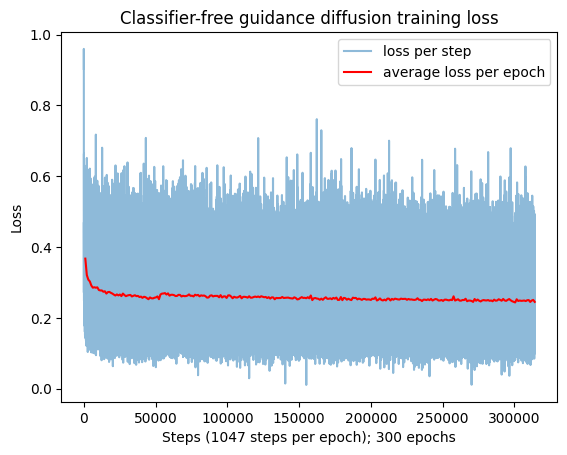

In [21]:
plt.plot(flat_losses, alpha=0.5, label='loss per step')
plt.plot(x_epoch_loss, y_epoch_loss, c='r', label='average loss per epoch')
plt.title("Classifier-free guidance diffusion training loss")
plt.ylabel("Loss")
plt.xlabel(f"Steps ({n_steps_per_epoch} steps per epoch); {n_epochs} epochs")
plt.legend()
plt.savefig("../results/xray-unet-04-26-2023--17-27-training-loss.png")
plt.show()

In [1]:
def save_generated_images_w_labels():
    pass

In [22]:
sampled_images, image_classes = th.sample_n_images(diffusion, 100, 2, 3.)

sampling loop time step: 100%|██████████| 500/500 [03:20<00:00,  2.50it/s]


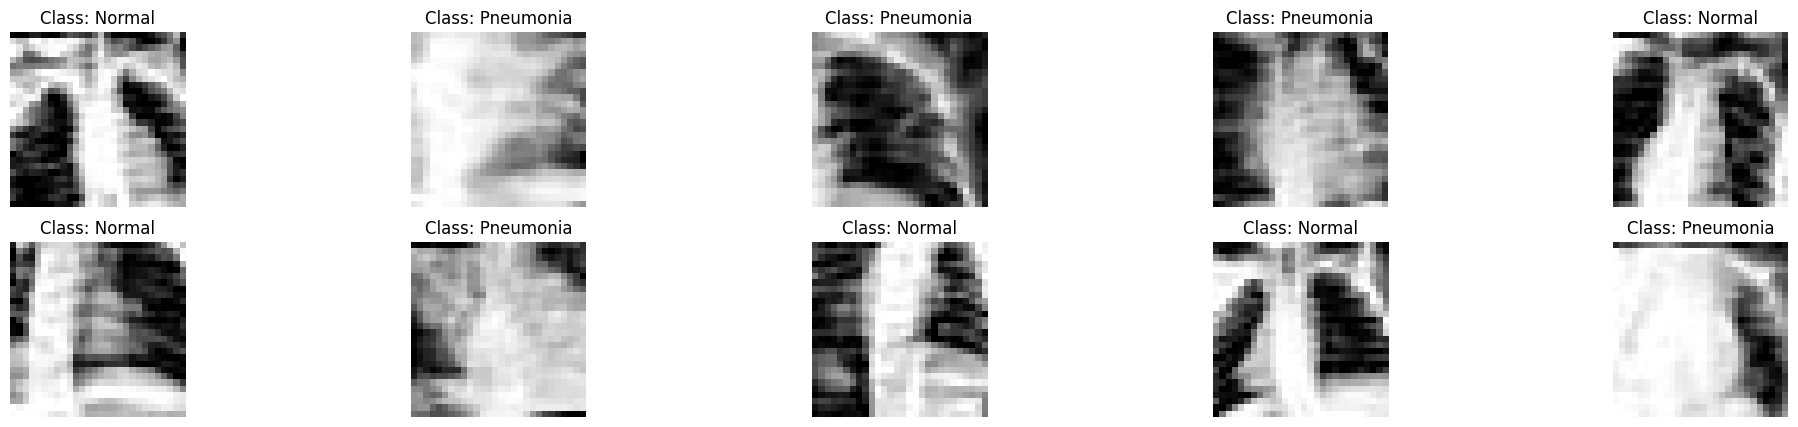

In [18]:
viz.plot_generated_images(sampled_images, image_classes, label_map, show=True)

In [24]:
from src import utils

In [26]:
for j, (image, label) in enumerate(zip(sampled_images, image_classes)):
    utils.save_image(image, f"../data/metric-comparison/xray/diffusion/epochs300/{label}-{j}.png")